### Download Data


In [278]:
import urllib
import urllib.request
from urllib.request import urlopen
import json
import nltk
import numpy as np
import matplotlib
import random
from random import randrange
import string  
from copy import deepcopy
import math
from IPython.display import FileLink, FileLinks
import pandas as pd
import re
from bs4 import BeautifulSoup
import requests
import pickle

#generate same random numbers:
random.seed(1)

In [279]:
### from the web, if in the UK:
uk=0
if uk==1:
    import urllib
    import urllib.request
    from bs4 import BeautifulSoup
    import numpy as np

    website='https://bnf.nice.org.uk/drug/'
    with urllib.request.urlopen(website) as response:
        webcont=response.read()
    soup=BeautifulSoup(webcont)
    data=soup.findAll(href=True)
    alllinks=list(data)

    linklist=[]
    for i in range(34,len(data)):
        endlink=str(data[i]).find('html')
        endlink+=4
        if str(data[i])[9]!='a':
            break
        linklist.append(str(data[i])[9:endlink])

    alldata=[]

    for i in range(len(linklist)):
        print(i)
        alldata.append(linklist[i][:-5])
        with urllib.request.urlopen(website+linklist[i]) as response:
            currwebcont=response.read()
        currsoup=BeautifulSoup(currwebcont)
        currdata=currsoup.findAll(text=True)

        def visible(element):
            if element.parent.name in ['style', 'script', '[document]', 'head', 'title']:
                return False
            elif re.match('<!--.*-->', str(element.encode('utf-8'))):
                return False
            return True

        result = filter(visible, currdata)
        ll=list(result)

        usell=[]
        n=0
        i=0
        k=0
        headers=[]

        while k==0 and i<200:
            if len(headers)==0 and ll[i]=='Indications and dose':
                headers.append(ll[i])
            elif len(headers)>0 and ll[i]!='\n':
                if ll[i]!='Indications and dose':
                    headers.append(ll[i])
                else:
                    k+=1
            i+=1
        i=i-1
        start=i
        headers.append('NICE Pathways')
        headerspos=[]

        head=0
        while i<len(ll) and len(headerspos)!=len(headers):
            if ll[i]==headers[head]:
                headerspos.append(i)
                head+=1
            i+=1

        for i in range(len(headerspos)-1):
            usell.append([])
            for j in range(headerspos[i],headerspos[i+1]):
                try:
                    string_new=str(ll[j].encode("cp1252").decode("utf8"))
                except:
                    string_new=str(ll[j])
                string_new=string_new.replace('\u202f',' ')
                string_new=string_new.replace('\n','')
                string_new=string_new.replace('–', '-')
                usell[i].append(string_new)
        alldata.append(usell)
        
        
else:
    #The BNF website is only available in the UK, therefore if you're located anyware else you have to use a VPN client and download
    #all websites manually and change the following folder locations due to your downloaded file location.
    
    filename = 'C:\\Users\\Oliver\\Desktop\\uni\\DataSc u MachLearn MSc\\project\\bnf_html\\alles.htm'
    html = open(filename, "r").read()
    #html = urllib2.urlopen('C:\\Users\\Oliver\\Desktop\\uni\\DataSc u MachLearn MSc\\project\\bnf_html\\alles.htm','r').read()
    #html = open('\\OLIVERPC\Users\Oliver\Desktop\uni\DataSc u MachLearn MSc\project\bnf_html\alles.htm')
    soup = BeautifulSoup(html)
    data = soup.findAll(text=True)
    
    
    hyperlinks=soup.findAll(href=True)
    alllinks=list(hyperlinks)
    druglinks=alllinks[52:1659]
    drugnames=[]
    drughref=[]
    
    for i, j in enumerate(druglinks):
        strin=str(druglinks[i])
        pos1=strin.find("href=")
        pos2=strin.find("><")
        pos3=strin.find("</sp")
        drughref.append(strin[pos1+5:pos2])
        drugnames.append(strin[pos2+7:pos3].lower())
        
    alldata=[]

    import glob, os
    os.chdir("C:\\Users\\Oliver\\Desktop\\uni\\DataSc u MachLearn MSc\\project\\bnf_html")
    for file in glob.glob("*.html"):

        alldata.append([])
        alldata[-1].append(file[:-5])
        currhtml = open('C:\\Users\\Oliver\\Desktop\\uni\\DataSc u MachLearn MSc\\project\\bnf_html\\' + file, "r").read()
        currsoup = BeautifulSoup(currhtml)
        currdata = currsoup.findAll(text=True)
        def visible(element):
            if element.parent.name in ['style', 'script', '[document]', 'head', 'title']:
                return False
            elif re.match('<!--.*-->', str(element.encode('utf-8'))):
                return False
            return True

        result = filter(visible, currdata)
        ll=list(result)

        usell=[]
        n=0
        i=0
        k=0
        headers=[]

        while k==0 and i<200:
            if len(headers)==0 and ll[i]=='Indications and dose':
                headers.append(ll[i])
            elif len(headers)>0 and ll[i]!='\n':
                if ll[i]!='Indications and dose':
                    headers.append(ll[i])
                else:
                    k+=1
            i+=1
        i=i-1
        start=i
        headers.append('NICE Pathways')
        headerspos=[]

        head=0
        while i<len(ll) and len(headerspos)!=len(headers):
            if ll[i]==headers[head]:
                headerspos.append(i)
                head+=1
            i+=1

        for i in range(len(headerspos)-1):
            usell.append([])
            for j in range(headerspos[i],headerspos[i+1]):
                string_new=str(ll[j].encode("cp1252").decode("utf8"))
                string_new=string_new.replace('\u202f',' ')
                string_new=string_new.replace('\n','')
                string_new=string_new.replace('–', '-')
                usell[i].append(string_new)

        alldata[-1].append(usell)


In [280]:
phamind={}
for j in range(len(alldata)):
    phamind[alldata[j][0]]=j

In [281]:
phamind["AMOXICILLIN"]

76

In [282]:
print(len(alldata))

132


In [283]:
sortdose=np.array([])

for j in range(len(alldata)):

    currdose=[]
    currdata=[]
    datapoint=alldata[j][1][0]
    posbyto=[]
    posfornorm=[]
    posforspec=[]
    i=0
    
    while i<len(datapoint):
        if datapoint[i]!='':
            #concatenate all normal fors with all following items until at least two of them are empty (strange html code for this header)
            if 'for' in datapoint[i].lower():
                k=1
                empty=0
                while empty<2 and k<7:
                    if datapoint[i+k]=='':
                        datapoint.insert(i,datapoint.pop(i)+datapoint.pop(i))
                        empty=empty+1
                        k=k+1
                    else:
                        datapoint.insert(i,datapoint.pop(i)+datapoint.pop(i))
                        k=k+1
            
            #Sometimes a headers item is saved partially in a few items because of a comma.
            if datapoint[i+1]==', ':
                datapoint.insert(i,datapoint.pop(i)+datapoint.pop(i)+datapoint.pop(i))
            #Sometimes a header is split up into more than one list item if it's too long:
            while datapoint[i+1]!='':
                datapoint.insert(i,datapoint.pop(i)+datapoint.pop(i))
            
            currdata.append(datapoint[i])
            
            #count blocks:
            if currdata[-1][:2].lower()=='by'  or currdata[-1][:6].lower()=='to the' or currdata[-1][:12].lower()=='initially by':
                posbyto.append(len(currdata)-1)
            elif currdata[-1][:9].lower()=='for adult' or currdata[-1][:9].lower()=='for child' or currdata[-1][:11].lower()=='for neonate' or currdata[-1][:11].lower()=='for elderly' or currdata[-1][:11].lower()=='for females':
                posfornorm.append(len(currdata)-1)
            elif currdata[-1][:4].lower()=='for ':
                posforspec.append(len(currdata)-1)
        i+=1
    
    #Delete all "special for" if after last "normal for"
    if posfornorm[-1]+2!=len(currdata):
        posforspec=[item for item in posforspec if item<posfornorm[-1]]
    
    #position of headers
    allpos=[x+1 for x in posfornorm]
    allpos=allpos+posfornorm+posbyto+posforspec
    posheaders=[item for item in range(1,len(currdata)) if item not in allpos]
    
    currdose=[[],[],[]] #name of phamaceutical first, second all different indications and doses
    currdose[0]=alldata[j][0]
    
    for i in posfornorm:
        currbyto=currdata[max([x for x in posbyto if x<i])]
        currheader=currdata[max([x for x in posheaders if x<i])]
        
        currcontent=currdata[i+1]
        if len(posforspec)>0:
            currforspec=currdata[max([x for x in posforspec if x<i])] + ' - '
        else:
            currforspec=''
            
        if currdata[i].find('For Adult')!=-1:
            currdose[1].append([currforspec + currheader,currbyto,currdata[i],currcontent])
    
    #if we have additional information add it to currdose[2]
    if posfornorm[-1]+2!=len(currdata):
        currdose[2]=currdata[posfornorm[-1]+2:len(currdata)]
    
    #add currdose to sortdose:
    if len(sortdose)==0:
        sortdose=[currdose]
    else:
        sortdose.append(currdose)

    

In [284]:
print(sortdose[75])

['AMOROLFINE', [['Fungal nail infections', 'By transungual application', 'For Adult', 'Apply 1-2 times a week for 6 months to treat finger nails and for toe nails 9-12 months (review at intervals of 3 months), apply to infected nails after filing and cleansing, allow to dry for approximately 3 minutes.']], []]


In [285]:
def abbrev(longterm):
    clist=[]
    if 'intravenous' in longterm:
        clist.append('IV')
    if 'mouth' in longterm:
        clist.append('PO')
    if 'inhalation' in longterm:
        clist.append('inh')
    if 'intramuscular' in longterm:
        clist.append('IM')
    if 'subcutaneous' in longterm:
        clist.append('SC')
    if 'intranasal' in longterm:
        clist.append('IN')
    if  'eye drop' in longterm:
        clist.append('eye drop')
    if 'rectum' in longterm:
        clist.append('PR')
    if 'transungual' in longterm:
        clist.append('transungual')
    if 'urethral' in longterm:
        clist.append('urethral')
    if 'ear' in longterm:
        clist.append('ear')
    if 'eye' in longterm and 'eye drop' not in longterm and 'eye ointment' not in longterm:
        clist.append('eye')
    if 'eye ointment' in longterm:
        clist.append('eye ointment')
    if 'skin' in longterm:
        clist.append('skin')
    if 'By regional administration' in longterm:
        clist.append('By regional administration')

    if 'intracavernosal' in longterm:
        clist.append('intracavernosal')
    if 'intravitreal' in longterm:
        clist.append('intravitreal')
    return(clist)


In [286]:
sdcopy=deepcopy(sortdose)
# sdchange
if 'sdchange' in globals():
    del sdchange
sdchange=np.array([])
sdchange=sdcopy[0][1]
sdchange[0][1]=abbrev(sdchange[0][1])
sdchange[0].insert(0,[sdcopy[0][0]])

for k in range(1,len(sortdose)):
    sdchange.extend(sdcopy[k][1])
    jlen=len(sdcopy[k][1])
    for j in range(jlen):
        sdchange[-(jlen-j)][1]=abbrev(sdchange[-(jlen-j)][1])
        if sdchange[-(jlen-j)][0][:3]=="For":
            pos=sdchange[-(jlen-j)][0].find('-')
            newmed=sdchange[-(jlen-j)][0][4:pos-1]
            sdchange[-(jlen-j)][0]=sdchange[-(jlen-j)][0][pos+2:]
            if newmed==sortdose[k][0]:
                sdchange[-(jlen-j)].insert(0,[sdcopy[k][0]])
            else:
                sdchange[-(jlen-j)].insert(0,[sdcopy[k][0],newmed])
            
        else:
            sdchange[-(jlen-j)].insert(0,[sdcopy[k][0]])


In [287]:
# Use only "normal" medicaments, without changing dose and frequency
# that often and ignore those with 'consult product literature' in the dose description

In [288]:
#find all doses including 'consult product literature' and delete them:

j=0
proof1='consult product literature'
proof2='consult local protocol'
proof3='Consult expert dental sources'
proof4='To be inserted into meatus or apply on a ribbon gauze dressing or sponge wick which should be kept saturated with the ear drops.'
while j < len(sdchange)-1:
    if proof1 in sdchange[j][-1] or proof2 in sdchange[j][-1] or proof3 in sdchange[j][-1] or proof4 in sdchange[j][-1]:
        sdchange.pop(j)
    else:
        j+=1
print(len(sdchange))

298


In [289]:
doseletters=[]
for i in range(len(sdchange)):
    doseletters.append(len(sdchange[i][-1]))


75.0
125.25
29.25
-158.625
154.5
342.375


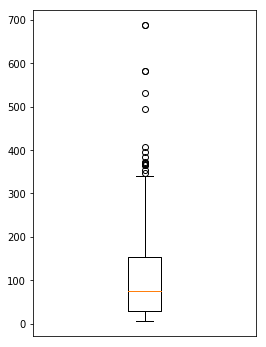

In [290]:
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize=(4, 6))
ax = fig.add_subplot(111)
ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
bp = ax.boxplot(doseletters)
fig.savefig('../fig1.png', bbox_inches='tight')

median = np.median(doseletters)
upper_quartile = np.percentile(doseletters, 75)
lower_quartile = np.percentile(doseletters, 25)

iqr = upper_quartile - lower_quartile
print(median)
print(iqr)
print(lower_quartile)
print(lower_quartile-1.5*iqr)
print(upper_quartile)
print(upper_quartile+1.5*iqr)

#upper_whisker = doseletters[doseletters<=upper_quartile+1.5*iqr].max()
#lower_whisker = doseletters[doseletters>=lower_quartile-1.5*iqr].min()

In [291]:
print(len(doseletters))

298


In [292]:
maxdoseletters=340
i=0
doselen=[]
while i < len(sdchange)-1:
    if len(sdchange[i][-1])>maxdoseletters:
        sdchange.pop(i)
    else:
        doselen.append(len(sdchange[i][-1]))
        i+=1
print(doselen.index(97))

209


In [293]:
print(sdchange[1])

[['ABACAVIR WITH LAMIVUDINE AND ZIDOVUDINE'], 'HIV infection (use only if patient is stabilised for 6-8 weeks on the individual components in the same proportions)', ['PO'], 'For Adult', '1 tablet twice daily.']


In [294]:
#Insert 7 columns to the list and copy paste the dose as memory
for i in range(len(sdchange)):
    sdchange[i].insert(-1,sdchange[i].pop(1))
    sdchange[i].insert(-1,sdchange[i][-1])
    for j in range(7):
        sdchange[i].insert(2,[])

In [295]:
for i in range(len(sdchange)):
    print(sdchange[i])


[['ABACAVIR WITH DOLUTEGRAVIR AND LAMIVUDINE'], ['PO'], [], [], [], [], [], [], [], 'For Adult (body-weight 40 kg and above)', 'HIV infection', '1 tablet once daily.', '1 tablet once daily.']
[['ABACAVIR WITH LAMIVUDINE AND ZIDOVUDINE'], ['PO'], [], [], [], [], [], [], [], 'For Adult', 'HIV infection (use only if patient is stabilised for 6-8 weeks on the individual components in the same proportions)', '1 tablet twice daily.', '1 tablet twice daily.']
[['ABACAVIR WITH LAMIVUDINE'], ['PO'], [], [], [], [], [], [], [], 'For Adult (body-weight 40 kg and above)', 'HIV infection in combination with other antiretrovirals', '1 tablet once daily.', '1 tablet once daily.']
[['ABACAVIR'], ['PO'], [], [], [], [], [], [], [], 'For Adult', 'HIV infection in combination with other antiretroviral drugs', '600 mg daily in 1-2 divided doses.', '600 mg daily in 1-2 divided doses.']
[['ABATACEPT'], ['IV'], [], [], [], [], [], [], [], 'For Adult (body-weight up to 60 kg)', 'Moderate-to-severe active rheu

In [296]:
# time abbrevations: https://bnf.nice.org.uk/about/abbreviations-and-symbols.html

# 'sdchange' - row:
# [[drugname(s)],[route(s)], dose, units, starting, frequency,
# min,max, duration, for whom, header, dose description,
# dose description to be changed]

# 1. Delete common start words: Apply, test dose, initially
# 2. Find Dose and units
for i in range(len(sdchange)):
    #delete spaces at beginning/end of string:
    sdchange[i][-1]=sdchange[i][-1].strip()
    #delete multiple spaces in string:
    sdchange[i][-1]=re.sub(' +', ' ', sdchange[i][-1])
    
    #Find Frequency
    ## including:
    ## - "x times a day" span,
    ## - "every x hours/minutes/..."
    ## - "once/twice daily/weekly (in (2-3) divided doses)"
    ## - "once a month/in divided doses/for x dose(s)" 
    
    freq=re.search('([0-9]*\.*[0-9]*-*[0-9]*\.*[0-9]+ times a day|every [0-9]*-*[0-9]+ (hours|minutes|years|weeks|days)|(once\s|twice\s)*(daily|weekly)(\sin [0-9]*-*[0-9]* *divided doses)*|(in divided doses|once a month|for [0-9]*-*[0-9]+ dose(s)*))', sdchange[i][-1])
    if freq!=None and freq!=[]:
        freqspan=freq.span()
        sdchange[i][5]=sdchange[i][-1][freqspan[0]:freqspan[1]]
        if sdchange[i][5]=="once daily" or sdchange[i][5]=="every day" or sdchange[i][5]=="daily":
            possibilities=["OD","o.d.","once daily","every day"]
            sdchange[i][5]=possibilities[random.randrange(0,len(possibilities))]
        if sdchange[i][5]=="twice daily" or sdchange[i][5]=="2 times a day":
            possibilities=["b.d.","BD","twice daily","2 times a day"]
            sdchange[i][5]=possibilities[random.randrange(0,len(possibilities))]
        if sdchange[i][5]=="4 times a day" or sdchange[i][5]=="four times daily":
            possibilities=["QDS","q.d.s"]
            sdchange[i][5]=possibilities[random.randrange(0,len(possibilities))]
        if sdchange[i][5]=="3 times a day" or sdchange[i][5]=="three times daily":
            possibilities=["TDS","TID","t.d.s.","t.i.d."]
            sdchange[i][5]=possibilities[random.randrange(0,len(possibilities))]
        if sdchange[i][5]=="every 4 hours" or sdchange[i][5]=="every four hours":
            possibilities=["q4h","q.4.h"]
            sdchange[i][5]=possibilities[random.randrange(0,len(possibilities))]
        if sdchange[i][5]=="for 1 dose":
            sdchange[i][5]="Once"
        sdchange[i][-1]=sdchange[i][-1][:freqspan[0]-1]+ sdchange[i][-1][freqspan[1]:]
    if sdchange[i][-1]=="":
        continue
    
    #if "Apply" at the beginning of the prescription, sometimes no dose number given -> special case
    if sdchange[i][-1].startswith("Apply"):
        sdchange[i][-1]=sdchange[i][-1][6:]
    elif sdchange[i][-1].startswith("Initially up to"):
        sdchange[i][-1]=sdchange[i][-1][16:]
    elif sdchange[i][-1].startswith("Test dose"):
        sdchange[i][-1]=sdchange[i][-1][10:]
    elif sdchange[i][-1].startswith("Usual dose"):
        sdchange[i][-1]=sdchange[i][-1][11:]
    elif sdchange[i][-1].startswith("Initially"):
        sdchange[i][-1]=sdchange[i][-1][10:]
    elif sdchange[i][-1].startswith("Not less than"):
        sdchange[i][-1]=sdchange[i][-1][14:] 
    
    sdchange[i][-1]=sdchange[i][-1].replace("units per ","units/")
    
    # Dose and unit at the beginning, if there is a number at the beginning:
    first=re.search(r"^\d",sdchange[i][-1])
    if first!=None and first!=[]:
        strsplit=sdchange[i][-1].split()
        sdchange[i][2]=strsplit[0]
        if len(strsplit)>1:
            sdchange[i][3]=strsplit[1]
            if len(strsplit)>2:
                remain=" ".join(strsplit[2:])
                sdchange[i][-1]=remain
            else:
                sdchange[i][-1]=""
                continue
        else:
            sdchange[i][-1]=""
            continue
    
    # find minimum ("to be given over... hours/minutes")
    minimum=re.search(r"to be given over .* \d* (hour(s)*|minute(s)*)",sdchange[i][-1])
    if minimum!=None and minimum!=[]:
        minspan=minimum.span()
        minimumstr=sdchange[i][-1][minspan[0]:minspan[1]]
        minsplit=minimumstr.split()
        sdchange[i][6]="Min "+minsplit[-2] + " " + minsplit[-1]
        sdchange[i][-1]=sdchange[i][-1][:minspan[0]-1] + sdchange[i][-1][minspan[1]:]
    if sdchange[i][-1]=="":
        continue
        
    # find maximum: (take the last maximum comment -> use re.findall and take last and then re.search)
    maximum=re.findall(r'max\.?[^{\),\.,\,;}]*[\)|\.|\,|;]?', sdchange[i][-1])
    if maximum!=None and maximum!=[]:
        maximumpos1=sdchange[i][-1].find(maximum[-1])
        lenmax=len(maximum[-1])
        maxstr=sdchange[i][-1][maximumpos1:maximumpos1+lenmax-1]              
        maxsplit=maxstr.split()
        sdchange[i][7]="Max "+" ".join(maxsplit[1:])
        sdchange[i][-1]=sdchange[i][-1][:maximumpos1-1] + sdchange[i][-1][maximumpos1 + lenmax+1:]   
    if sdchange[i][-1]=="":
        continue
        
    ####################### TO BE DONE!!!! -> ABBREV as in example/BNF    
    ####### Let's have a look how all other letters (B-Z) will look like
    
        
    # find starting: (morning, before lunch, after lunch, evening)
    startmorning=re.search(r'in the morning',sdchange[i][-1])
    if startmorning!=None and startmorning!=[]:
        possibilities=["6am","8am","in the morning"]
        sdchange[i][4]=possibilities[random.randrange(0,len(possibilities))]
        
    beforefood=re.search(r'before food', sdchange[i][-1])
    if beforefood!=None and beforefood!=[]:
        possibilities=["ac","AC","a.c.","before food"]
        sdchange[i][4]=possibilities[random.randrange(0,len(possibilities))]
        
    afterfood=re.search(r'after food', sdchange[i][-1])
    if afterfood!=None and afterfood!=[]:
        possibilities=["pc","PC","p.c.","after food"]
        sdchange[i][4]=possibilities[random.randrange(0,len(possibilities))]
        
    startevening=re.search(r'[at night|at bedtime|in the evening]',sdchange[i][-1])
    if startevening!=None and startevening!=[]:
        possibilities=["8pm","10pm","at night"]
        sdchange[i][4]=possibilities[random.randrange(0,len(possibilities))]
    
    startnow=re.search(r'[at first sign|immediately]',sdchange[i][-1])
    if startnow!=None and startnow!=[]:
        sdchange[i][4]="stat"
    startprn=re.search(r'[when required|as required|if required]',sdchange[i][-1])
    if startprn!=None and startprn!=[]:
        possibilities=["prn","p.r.n.","PRN","as required"]
        sdchange[i][4]=possibilities[random.randrange(0,len(possibilities))]
        if sdchange[i][5]=="":
            sdchange[i][5]="PRN"
  
    # find duration:
    duration=re.search(r'for [0-9]*-*[0-9]+ [(day(s)*)|(dose(s)*)|(year(s)*)|(week(s)*)|(month(s)*)]+',sdchange[i][-1])
    if duration!=None and duration!=[]:
        durationspan=duration.span()
        durationstr=sdchange[i][-1][durationspan[0]:durationspan[1]]
        durationsplit=durationstr.split()
        sdchange[i][8]=durationsplit[-2] + " " + durationsplit[-1]
        sdchange[i][-1]=sdchange[i][-1][:durationspan[0]-1] + sdchange[i][-1][durationspan[1]:]
    if sdchange[i][-1]=="":
        continue
        
# delet all commas, dots at beginning or end of blocks:
for i in range(len(sdchange)):
    for j in range(2,9):
        if len(sdchange[i][j])!=0:
            sdchange[i][j]=sdchange[i][j].strip()
            if sdchange[i][j][0]=="," or sdchange[i][j][0]=="." or sdchange[i][j][0]==";":
                sdchange[i][j]=sdchange[i][j][1:]
            if sdchange[i][j][-1]=="," or sdchange[i][j][-1]=="." or sdchange[i][j][-1]==";":
                sdchange[i][j]=sdchange[i][j][:-1]

In [297]:
def is_int(inp):
    try: 
        int(inp)
        return True
    except ValueError:
        return False

In [298]:
#ADD NOISE to whole prescription:

def addnoise(inp,prob):
    #inp..input string
    #prob..probability of having noise
    
    if pd.isnull(inp)==True or inp=="":
        return ""
    
    
    cnlist=list(str(inp))
    j=0
    while j< len(cnlist):
        if cnlist[j]!=" " and random.random()<=prob:
        #delete/copy/change:
        # dcc=0 .. delete (but not the whole word/numb, sth. should remain)
        # dcc=1 .. copy
        # dcc=2 .. change
        # dcc=3 .. swap j<->j+1
            if j==len(cnlist)-1: #if it's the last character it can't be swaped with the next one.
                dcc=randrange(0,3)
                if len(cnlist)==1: #if only one character at all, don't delete it
                    dcc=randrange(1,3)
                elif cnlist[j-1]==" ": #if last character stands alone don't delete it
                    dcc=randrange(1,3)
                
            else:
                dcc=randrange(0,4)
                if j==0 and cnlist[j+1]== " ": #if first character stands alone don't delete it and swap is not possible
                    dcc=randrange(1,3)
                if j!=0 and cnlist[j-1]==" " and cnlist[j+1]==" ": #don't delete any character which stands alone
                    dcc=randrange(1,3)
                    
            if dcc==0:
                cnlist.pop(j)
                j-=1
            elif dcc==1:
                cnlist.insert(j,cnlist[j])
                j+=1
            elif dcc==2:
                if is_int(cnlist[j])==True:
                    cnlist[j]=str(random.randint(0,9))
                elif cnlist[j].isupper()==True:
                    cnlist[j]=random.choice(string.ascii_uppercase)
                else:
                    cnlist[j]=random.choice(string.ascii_lowercase)
            elif dcc==3 and cnlist[j+1]!=" ":
                currj=cnlist[j]
                cnlist[j]=cnlist[j+1]
                cnlist[j+1]=currj
                j+=1
        j+=1
    return "".join(cnlist)

# For Evaluation - Training sets - 10-Fold

In [299]:
# [[drugname(s)],[route(s)], dose, units, starting, frequency,
# min,max, duration, for whom, header, dose description,
# dose description to be changed]

#Derive a certain number of synthesized data:

numb=10000 #number of synthesized data
noise=0.10 #10% noise

In [300]:
folds=10
fold_len=np.floor(len(sdchange)/folds)
fold_num=np.int(np.floor(numb/folds))

fold1=[]
fold2=[]
fold3=[]
fold4=[]
fold5=[]

fold_numb=[]
for i in range(folds):
    if i+1<folds:
        fold_numb.append([np.int(i*fold_len),np.int((i+1)*fold_len)])
    else:
        fold_numb.append([np.int(i*fold_len),len(sdchange)])


In [301]:

if 'fold_data' in globals():
    del fold_data
fold_data=[]

for fold in range(len(fold_numb)):
    curr_fold_data=[]
    for k in range(fold_num):
        randdrug=randrange(fold_numb[fold][0], fold_numb[fold][1])
        currdrug=deepcopy(sdchange[randdrug])
     
        #drug name:
        randnr=0
        if len(currdrug[0])>1:
            randnr=randrange(0,len(currdrug[0]))
        currname=currdrug[0][randnr]
        posR=currname.find('®')
        if posR!=-1:
            currname=currname[:posR]+currname[posR+1:]

        #drug dose:
        if currdrug[2]!=[]:
            minslashpos=re.search("[-,/]",currdrug[2])
            if minslashpos!=None:
                posspan=minslashpos.span()
                val1=float(currdrug[2][:posspan[0]])
                val2=float(currdrug[2][posspan[1]:])
                zeroone=randrange(0,2)
                finalval=zeroone*val1+(1-zeroone)*val2
                if finalval==int(finalval):
                    finalval=int(finalval)
                currdose=str(finalval)
            else:
                currdose=str(currdrug[2])
                #if int(float(currdrug[2]))==float(currdrug[2]):
                #    currdose=str(int(currdrug[2]))
                #else:
                #    currdose=float(currdrug[2])
        else:
            currdose=""



        #drug units:
        if currdrug[3]!=[]:
            kgsearch=re.search("/kg",currdrug[3])
            if kgsearch!=None:
                kgspan=kgsearch.span()
                currdrug[3]=currdrug[3][0:kgspan[0]]

                #due to a paper we have the following distribution
                # .. with mean, stdev, min, max
                randkg=round(np.exp(np.random.normal(4.411,0.145)))
                while randkg<np.exp(3.965) and randkg>np.exp(5.002):
                    randkg=round(np.exp(np.random.normal(4.411,0.145)))

                #at least round currdose to 0.1
                currdose=round(float(currdose)*randkg,1)
                #if number bigger 100 round to second highest value: f.e 111->110
                if currdose>100:
                    currdosel10=np.floor(math.log10(currdose))-1
                    currdose=int(round(currdose/(10**currdosel10))*(10**currdosel10))
            currunit=currdrug[3]
        else:
            currunit=""



        #drug starting:
        if currdrug[4]!=[]:
            currstart1=currdrug[4]
        else:
            times=["8am","10am","1pm","5pm","8pm"]
            randnr=randrange(0,5)
            currstart1=times[randnr]
        add_starting=["start","starting"]
        currstart=add_starting[randrange(0,2)]+" "+currstart1

        #drug frequency:
        if currdrug[5]!=[]:
            currfreq=currdrug[5]
        else:
            currfreq=""

        #drug route:
        randnr=0
        if len(currdrug[1])>1:
            randnr=randrange(0,len(currdrug[1]))
        currroute=currdrug[1][randnr]
        if currdrug[1]==[]:
            currroute=""

        #drug max:
        if currdrug[7]!=[]:
            currmax=currdrug[7]
        else:
            currmax=""

        #drug min:
        if currdrug[6]!=[]:
            currmin=currdrug[6]
        else:
            currmin=""

        #drug duration:
        if currdrug[8]!=[]:
            currdur=currdrug[8]
        else:
            currdur=""

        #add noise to all:
        namen=addnoise(currname,noise)
        dosen=addnoise(currdose,noise)
        unitn=addnoise(currunit,noise)
        startn=addnoise(currstart,noise)
        freqn=addnoise(currfreq,noise)
        routen=addnoise(currroute,noise)
        maxn=addnoise(currmax,noise)
        minn=addnoise(currmin,noise)
        durn=addnoise(currdur,noise)

        #all together, which should be the description input in the software, where the first one is the drug name,
        #but the rest is in randomly ordered (delete multiple spaces):
        currall=[namen," ".join([str(dosen),str(unitn)]),startn,freqn,routen,maxn,minn,durn]

        currneworder=[]
        currsamp=random.sample([0,1,2,3,4,5,6,7],8)
        for i in range(8):
            currneworder.append(str(currall[currsamp[i]]))
        currges=" ".join(currneworder)
        currges=currges.strip()
        currges=re.sub(' +', ' ', currges)

        curr_fold_data.append([currname,str(currdose),str(currunit),currstart,currfreq,currroute,currmax,currmin,currdur,namen,dosen,unitn,startn,freqn,routen,maxn,minn,durn,currsamp,currges])
        
    fold_data.append(curr_fold_data)

In [302]:
os.chdir('C:\\Users\\Oliver\\Desktop\\uni\\DataSc u MachLearn MSc\\project')

In [303]:
with open("fold_data.txt", "wb") as fp:   #Pickling
    pickle.dump(fold_data, fp)

# Human is a creature of habit

In [305]:

if 'fold_data_h' in globals():
    del fold_data_h
fold_data_h=[]

for fold in range(len(fold_numb)):
    curr_fold_data=[]
    for k in range(fold_num):
        randdrug=randrange(fold_numb[fold][0], fold_numb[fold][1])
        currdrug=deepcopy(sdchange[randdrug])
     
        #drug name:
        randnr=0
        if len(currdrug[0])>1:
            randnr=randrange(0,len(currdrug[0]))
        currname=currdrug[0][randnr]
        posR=currname.find('®')
        if posR!=-1:
            currname=currname[:posR]+currname[posR+1:]

        #drug dose:
        if currdrug[2]!=[]:
            minslashpos=re.search("[-,/]",currdrug[2])
            if minslashpos!=None:
                posspan=minslashpos.span()
                val1=float(currdrug[2][:posspan[0]])
                val2=float(currdrug[2][posspan[1]:])
                zeroone=randrange(0,2)
                finalval=zeroone*val1+(1-zeroone)*val2
                if finalval==int(finalval):
                    finalval=int(finalval)
                currdose=str(finalval)
            else:
                currdose=str(currdrug[2])
                #if int(float(currdrug[2]))==float(currdrug[2]):
                #    currdose=str(int(currdrug[2]))
                #else:
                #    currdose=float(currdrug[2])
        else:
            currdose=""



        #drug units:
        if currdrug[3]!=[]:
            kgsearch=re.search("/kg",currdrug[3])
            if kgsearch!=None:
                kgspan=kgsearch.span()
                currdrug[3]=currdrug[3][0:kgspan[0]]

                #due to a paper we have the following distribution
                # .. with mean, stdev, min, max
                randkg=round(np.exp(np.random.normal(4.411,0.145)))
                while randkg<np.exp(3.965) and randkg>np.exp(5.002):
                    randkg=round(np.exp(np.random.normal(4.411,0.145)))

                #at least round currdose to 0.1
                currdose=round(float(currdose)*randkg,1)
                #if number bigger 100 round to second highest value: f.e 111->110
                if currdose>100:
                    currdosel10=np.floor(math.log10(currdose))-1
                    currdose=int(round(currdose/(10**currdosel10))*(10**currdosel10))
            currunit=currdrug[3]
        else:
            currunit=""



        #drug starting:
        if currdrug[4]!=[]:
            currstart1=currdrug[4]
        else:
            times=["8am","10am","1pm","5pm","8pm"]
            randnr=randrange(0,5)
            currstart1=times[randnr]
        add_starting=["start","starting"]
        currstart=add_starting[randrange(0,2)]+" "+currstart1

        #drug frequency:
        if currdrug[5]!=[]:
            currfreq=currdrug[5]
        else:
            currfreq=""

        #drug route:
        randnr=0
        if len(currdrug[1])>1:
            randnr=randrange(0,len(currdrug[1]))
        currroute=currdrug[1][randnr]
        if currdrug[1]==[]:
            currroute=""

        #drug max:
        if currdrug[7]!=[]:
            currmax=currdrug[7]
        else:
            currmax=""

        #drug min:
        if currdrug[6]!=[]:
            currmin=currdrug[6]
        else:
            currmin=""

        #drug duration:
        if currdrug[8]!=[]:
            currdur=currdrug[8]
        else:
            currdur=""

        #add noise to all:
        namen=addnoise(currname,noise)
        dosen=addnoise(currdose,noise)
        unitn=addnoise(currunit,noise)
        startn=addnoise(currstart,noise)
        freqn=addnoise(currfreq,noise)
        routen=addnoise(currroute,noise)
        maxn=addnoise(currmax,noise)
        minn=addnoise(currmin,noise)
        durn=addnoise(currdur,noise)

        #all together, which should be the description input in the software, where the first one is the drug name,
        #but the rest is in randomly ordered (delete multiple spaces):
        currall=[namen," ".join([str(dosen),str(unitn)]),startn,freqn,routen,maxn,minn,durn]
        
        currneworder=[]
        currsamp=[0,1,2,3,4,5,6,7]
        #for i in range(7):
        #    if random.random()<0.1:
        #        currsamp[i]=i+1
        #        currsamp[i+1]=i
        
        for i in range(8):
            currneworder.append(str(currall[currsamp[i]]))
        
        currges=" ".join(currneworder)
        currges=currges.strip()
        currges=re.sub(' +', ' ', currges)

        curr_fold_data.append([currname,str(currdose),str(currunit),currstart,currfreq,currroute,currmax,currmin,currdur,namen,dosen,unitn,startn,freqn,routen,maxn,minn,durn,currsamp,currges])
    fold_data_h.append(curr_fold_data)

In [306]:
with open("fold_data_h.txt", "wb") as fp:   #Pickling
    pickle.dump(fold_data_h, fp)